In [1]:
import qutip as qt
from qutip_qip.operations.gates import hadamard_transform as hadamard

import numpy as np
from matplotlib import pyplot as plt

import jax
import jax.numpy as jnp
from diffrax import Dopri5, PIDController, Dopri8

from optimize import optimize_pulses
from time_interval import TimeInterval
from objective import Objective

# Quantum Optimal Control Task

We want to transform an initial system $X$ through application of $H$ into a desired target $X_\mathrm{trgt}$.

\begin{gather*}
    X(t=0) \underset{H}{\longrightarrow} X_\mathrm{trgt}=X(t=T)
\end{gather*}

The transformation must obay the Schrödinger equation

\begin{gather}
    \partial_{t} X(t) = - \mathrm i \underbrace{\left( A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k \right)}_{H} X(t)
\end{gather}

for closed systems. Different settings are possible

\begin{array}{c|c|c|c}
 & \text{drift } A        & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}  &  H_d         &  B_k& |\Psi(t, \alpha)>\\
 \text{gate synthesis}       &  H_d         &  B_k & U(t, \alpha)   \\\hline
 \text{state transfer}      &  \hat H_d    &  \hat B_k & \rho(t, \alpha) \\
 \text{gate synthesis}     &  \hat H_d    &  \hat B_k & \hat{U}(t, \alpha)
\end{array}

where super-operators are labeled by a hat. Two possible figures of merit are 
$f_\mathrm{SU} = \mathrm{Re}(g) \text{ and } f_\mathrm{PSU} = |g|$

\begin{gather*}
    g = \frac{1}{\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[X_\mathrm{trgt}^{\dagger} X(T, \alpha) \right]
\end{gather*}

Open systems must obay the Master equation with Lindbladian $\hat L$ and trace difference $f_\mathrm{TRCDFF} = \mathrm{Re}(d)$ as possible distance measure.

\begin{array}{c|c|c|c}
  & \text{drift } A   & \text{controls } B_k & X(t, \alpha) \\\hline
 \text{state transfer}     &  \hat H_d +
 \mathrm i \hat{L}    &  \hat B_k& \rho(t, \alpha) \\
 \text{map synthesis}         &   \hat H_d + \mathrm i \hat L    &  \hat B_k& \hat{U}(t, \alpha)\\
\end{array}

\begin{gather*}
    d = \frac{1}{2\|{X_\mathrm{trgt}} \|} \mathrm{tr} \left[ (X(T, \alpha) - X_\mathrm{trgt})^\dagger  (X(T, \alpha) - X_\mathrm{trgt})\right]
\end{gather*}

---
# GRadient Ascent Pulse Engineering (GRAPE)
---

Slice time interval $T$ in $M$ chunks of size $\Delta t$, with piecewise constant functions $c_j(t_i, \vec \alpha) = \mathrm{const.}$ for $i \in [1, M]$

\begin{gather*}
H(t_i, \alpha) \approx A + \sum_{k=0}^{C-1} \alpha_{i,k} B_k \\

X(t_i, \alpha) = \underbrace{X_i}_{\exp(-\mathrm i H(t_i, \alpha) \Delta t)}
X_{i-1} \dots X_1 X_0
\end{gather*}

update parameters according to $\frac{\partial f^{(r)}(X(t, \alpha))}{\partial \alpha_{i,k}}$

<img src="doc_images\DYNAMO.png" alt="dynamo" width="600"/>

---
# Chopped RAndom Basis (CRAB)
---

Update initial guess controls $c^{\text{ init}}_k(t, \vec \alpha_k)$ through parameterized update function $g_k(t, \vec \beta_k)$ expanded in some function basis i.e. Fourier:

\begin{align*}
    c^{\text{ update}}_k(t, \vec \alpha_k) &= c^{\text{ init}}_k(t, \vec \alpha_k) \cdot g_k(t, \vec \beta_k) \\ \\
    &= c^{\text{ init}}_k(t, \vec \alpha_k) \left( 1 +
    \sum_{l=1}^{\infty} A_l \sin ( \omega_l t) + B_l \cos ( \omega_l t) \right)
\end{align*}

fix + randomly choose $\omega_l$ and chop to finite basis $l\in[1, L]$

<img src="doc_images\CRAB.png" alt="crab" width="800"/>

---
# Gradient Optimization of Analytic conTrols (GOAT)
---

\begin{align}
    \mathrm i\partial_{t} X = & \phantom{xx} H X\\
    \mathrm i\partial_{\alpha}\partial_{t} X = &\partial_{\alpha}  H X
\end{align}

\begin{gather*}
   {\overset{\text{RHS}}{\longrightarrow}} \begin{pmatrix}
        H & 0 \\
        \partial_{{\alpha}}{H}& H \\
    \end{pmatrix}
    \begin{pmatrix}
        X \\
        \partial_{{\alpha}}{X} \\
    \end{pmatrix}
    = \begin{pmatrix}
        H X \\
        (\partial_{{\alpha}}{H}) X + H (\partial_{{\alpha}}{X}) \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        H & 0 & 0 & 0\\
        \partial_{\vec{\alpha}_0}{H}& H & 0 & 0 \\
        \partial_{\vec{\alpha}_1}{H}& 0 & H & 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
     \begin{pmatrix}
        X \\
        \partial_{\vec{\alpha}_0}{X} \\
        \partial_{\vec{\alpha}_1}{X} \\
        \vdots \\
    \end{pmatrix}
    \\ \\ 
\end{gather*}




Algebra ...

\begin{gather*}
   =
    \begin{pmatrix}
        A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)& A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        \sum_{k=0}^{C-1} B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & A + \sum_{k=0}^{C-1} c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    \\ \\ =
    \begin{pmatrix}
        A & 0 & 0 & 0\\
        0& A & 0 & 0 \\
        0& 0 & A & 0 \\
        0 & 0 & 0 & \ddots \\
    \end{pmatrix}
    +\sum_{k=0}^{C-1}
    \begin{pmatrix}
        c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 & 0\\
        B_k\,\partial_{\vec{\alpha}_0} c_k(\vec{\alpha}_k, t)&  c_k(\vec{\alpha}_k, t) B_k\,& 0 & 0 \\
        B_k\,\partial_{\vec{\alpha}_1} c_k(\vec{\alpha}_k, t)& 0 & c_k(\vec{\alpha}_k, t) B_k\,& 0 \\
        \vdots & 0 & 0 & \ddots \\
    \end{pmatrix}
    
    
\end{gather*}

\begin{gather*} =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \begin{pmatrix}
        0 & 0 &  \\
        B_0\, \partial_{\vec{\alpha}_0} c_0(\vec{\alpha}_0, t)& 0 & \\
        B_1\,\partial_{\vec{\alpha}_1} c_1(\vec{\alpha}_1, t)& 0  & \\
        \vdots &  & \ddots \\
    \end{pmatrix}
    \\ \\ =
    (\mathbf{I} \otimes A) + \sum_{k=0}^{C-1}
    (\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t) +
    \sum_{k=0}^{C-1} (\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k}} c_k(\vec{\alpha}_k, t)
\end{gather*}

Details ...
where $\mathbf{1}_{0,k+1}$ is the zero square matrix with only one entry in the first column at row index $1 + (k \cdot M + l)$ set to one, and ($l$ index of) $M$

is the number of varaible parameters for each control amplitude $c_k(\vec{\alpha}_k, t)$, i.e. for a superposition of Gaussian pulses with three variable parameters each $\rightarrow M = 3 \cdot m$:
\begin{gather*}
    c_k(\vec{\alpha}_k, t) = \sum_{l=0}^{M-1} A_{k,l} \exp\left({\frac{-(t-\tau_{k,l})^2}{\sigma_{k,l}^2}}\right)
\end{gather*}

Expressing the Hamiltonian in this form makes it comfortable to implement it using QuTiP
\begin{gather*}
    \underbrace{(\mathbf{I} \otimes A)}_{\mathrm{QobjEvo(}\tilde{H}_d,f(x)=1)}
     + \sum_{k=0}^{C-1}\underbrace{(\mathbf{I} \otimes B_k) c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,c_k(\vec{\alpha}_k, t))}
     + \sum_{k=0}^{C-1} \sum_{l=0}^{M-1} \underbrace{(\mathbf{1}_{0,k+1} \otimes B_k) \partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t)}_{\mathrm{QobjEvo(}\tilde{H}_k,\partial_{{\alpha}_{k,l}} c_k(\vec{\alpha}_k, t))}
\end{gather*}

Complexity ...

We have now $1 + C + C \cdot M = O(C \cdot M)$ summands, i.e. the term grows linear with the number of parameters $N_{\mathrm{para}} = C \cdot M$

The size of the matrix however grows with $O(N_{\mathrm{para}} \cdot \mathrm{dim}(A))$

---
# Example: Hadamard Gate (two level system)
---

\begin{gather*}
    X(t=0) = \mathbf{I} \longrightarrow X(T) = \mathrm{H} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{gather*}

In [2]:
initial = qt.qeye(2)
target = hadamard()

initial = qt.sprepost(initial, initial.dag())
target = qt.sprepost(target, target.dag())

\begin{gather}
    \partial_{t} X(t) =-\frac{i}{\hbar}[H(\vec{\alpha}, t), X(t)]+ \frac{1}{2} \left[2 C X(t) C^\dagger - X(t) C^\dagger C - C^\dagger C X(t)\right] \\
\end{gather}

\begin{gather*}
    H(\vec{\alpha}, t) = \underbrace{
            \frac{1}{2} \left(\omega \sigma_z +  \Delta \sigma_x\right)
        }_{H_d} 
    + H_c(\vec{\alpha}, t) \text{ and }C = \sqrt \gamma a
\end{gather*}

Time independent drift Hamiltonian

In [3]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

# energy splitting, tunneling, amplitude damping
ω, Δ, γ = 0.1, 1.0, 0.1

Hd = 1 / 2 * (ω * σz + Δ * σx)

H_d = qt.liouvillian(H=Hd, c_ops=[np.sqrt(γ) * qt.sigmam()])

In [4]:
π = np.pi
num_ts = 100
interval = TimeInterval(evo_time=2 * π, n_tslots=num_ts)

In [5]:
Hc = [σx, σy, σz]
H_c = [qt.liouvillian(H) for H in Hc]

init_x = np.ones(num_ts)
init_y = np.ones(num_ts)
init_z = np.ones(num_ts)

H = [H_d,
     [H_c[0], init_x],
     [H_c[1], init_y],
     [H_c[2], init_z]]

In [6]:
print(qt.create(2))

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]


10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.3%. Run time:   0.00s. Est. time left: 00:00:00:00
40.4%. Run time:   0.00s. Est. time left: 00:00:00:00
50.5%. Run time:   0.00s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.01s. Est. time left: 00:00:00:00
80.8%. Run time:   0.01s. Est. time left: 00:00:00:00
90.9%. Run time:   0.01s. Est. time left: 00:00:00:00
100.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

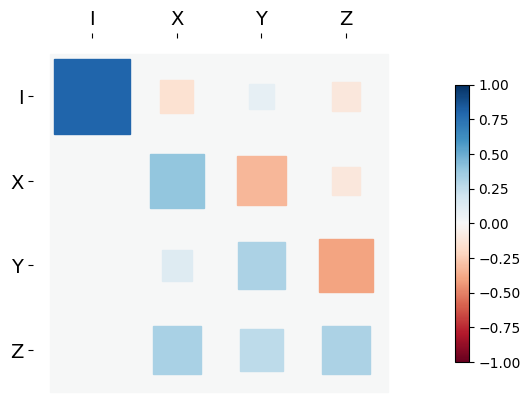

In [7]:
init_evo = qt.mesolve(H, initial, interval.tslots)

qt.hinton(init_evo.final_state)

# QuTiP GRAPE

<img src="doc_images\QOC.png" alt="qoc" width="600"/>

In [8]:
res_grape = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess": init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess": init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess": init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "GRAPE",
        "fid_err_targ": 0.01,
        "max_iter": 1000,
    },
)

In [9]:
res_grape

Control Optimization Result
       --------------------------
       - Started at 2023-12-09 22:12:21
       - Number of objectives: 1
       - Final fidelity error: 0.043930087477972515
       - Final parameters: [[-0.66166923 -0.65927945  0.50518739  0.59680038  0.08848747  0.1413621
  0.70527128  0.55058863 -0.38454973  0.87944541  0.77035208  0.78752788
  0.07235665  0.2201283   0.61417832  0.18241106  0.79174792  0.99997312
  0.99984543  0.94055401  0.99985246  0.99985     0.99986295  0.99988776
  0.1003153   0.99997512  0.49718312  0.94925822 -0.40232088 -0.3077414
  0.37006789 -0.01444377 -0.6321799  -0.12114715  0.64608506  0.57920624
 -0.04529355 -0.71566324  0.45216366  0.05928057  0.51931714  0.54866072
  0.48450118  0.13902864  0.08431804 -0.08227798 -0.2522228   0.89538728
  0.0954621   0.24392951 -0.12083409  1.          0.19045606 -0.03518493
  0.95355126  0.15610876  0.62170636  0.47327317  0.27528921 -0.28431494
 -0.50665999 -0.5351012   0.01791949  0.6618778  -0.17109

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

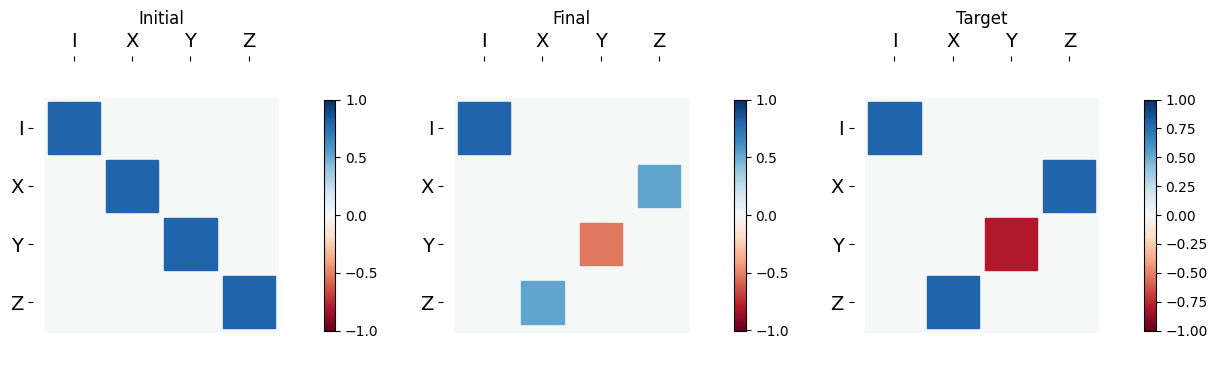

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_grape.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

# QuTiP CRAB

In [11]:
res_crab = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "ctrl_x": {
            "guess": init_x,
            "bounds": [-1, 1],
        },
        "ctrl_y": {
            "guess": init_y,
            "bounds": [-1, 1],
        },
        "ctrl_z": {
            "guess": init_z,
            "bounds": [-1, 1],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "CRAB",  # new
        "fid_err_targ": 0.01,
    }
)

In [12]:
res_crab

Control Optimization Result
       --------------------------
       - Started at 2023-12-09 22:12:25
       - Number of objectives: 1
       - Final fidelity error: 0.0441039007632429
       - Final parameters: [[ 0.45249011  0.37472031  0.27147378  0.1436265  -0.0038238  -0.16120953
 -0.31592986 -0.45608549 -0.57386724 -0.66670867 -0.73615131 -0.78580038
 -0.8196084  -0.84089569 -0.85195365 -0.8539353  -0.84680116 -0.82918184
 -0.79809568 -0.74855606 -0.67331591 -0.5634431  -0.41099728 -0.21479413
  0.01289061  0.24580265  0.45438247  0.6199108   0.73938785  0.8202159
  0.87281055  0.90629003  0.92723525  0.93992681  0.94694817  0.949705
  0.94875384  0.94394608  0.9344079   0.91836462  0.89281793  0.85313693
  0.79279534  0.70383387  0.57899133  0.41605999  0.2227727   0.01758155
 -0.17676676 -0.34267962 -0.47262017 -0.56750452 -0.63235932 -0.67279185
 -0.69319369 -0.69615191 -0.68240677 -0.65099792 -0.59954019 -0.52479271
 -0.42380905 -0.29583777 -0.14454702  0.02079285  0.18675264

(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

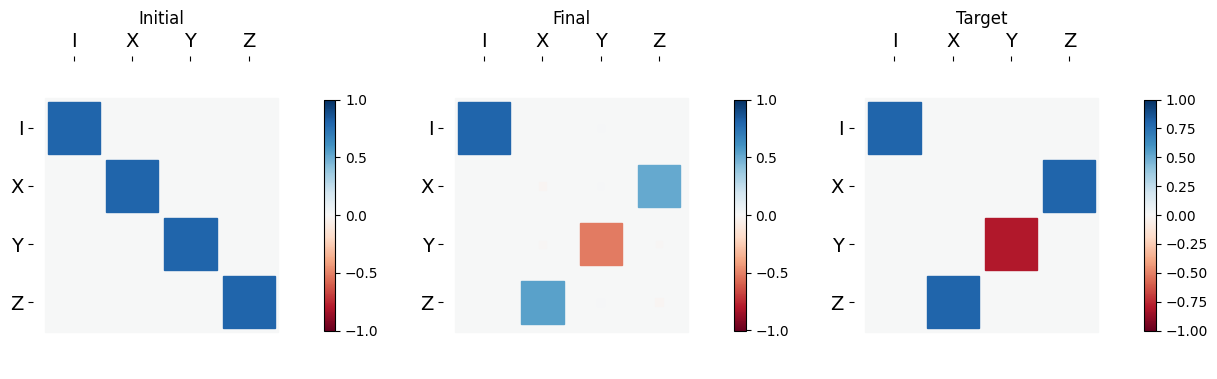

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_crab.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)

In [14]:
def plot_result(
    res,
    title,
    y_labels=[
        "$\\sigma_x$",
        "$\\sigma_y$",
        "$\\sigma_z$"]):

    fig, ax = plt.subplots(len(res.optimized_controls),
                           1, figsize=(15, 12), sharex=True)

    ax[0].set_title(title, fontsize=20)

    for i in range(len(res.optimized_controls)):

        ax[i].xaxis.set_label_text('Time')

        ax[i].yaxis.set_label_text('Control ' + y_labels[i])

        ax[i].plot(
            res.time_interval.tslots,
            res.guess_controls[i],
            label='Guess')

        ax[i].plot(
            res.time_interval.tslots,
            res.optimized_controls[i],
            label='Optimized')

        ax[i].legend()

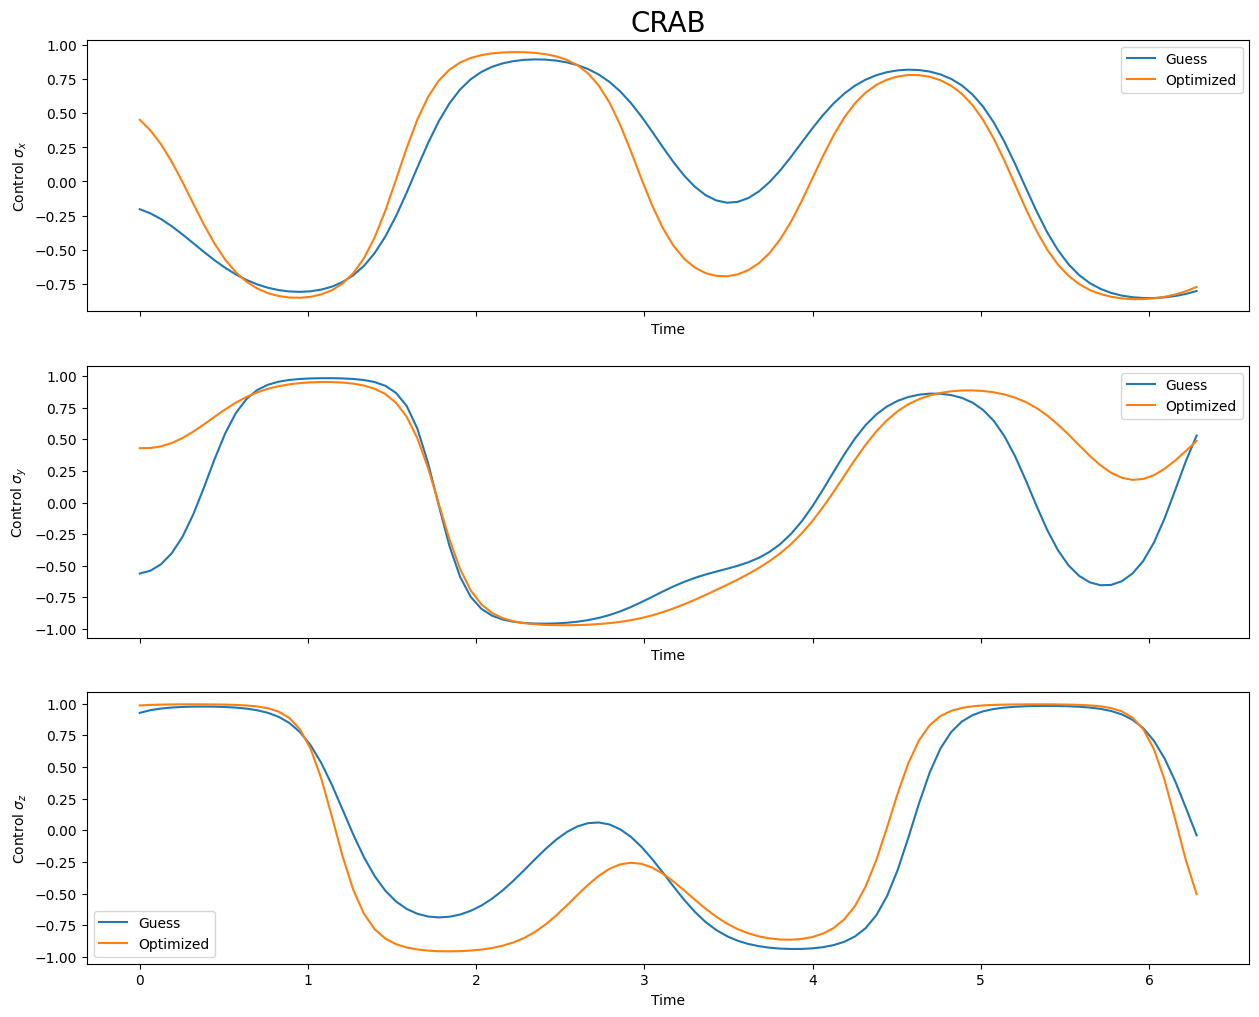

In [15]:
plot_result(res_crab, "CRAB")

# QuTiP GOAT

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

In [16]:
def sin(t, α):
    return α[0] * np.sin(α[1] * t + α[2])


def grad_sin(t, α, idx):
    if idx == 0:
        return np.sin(α[1] * t + α[2])
    if idx == 1:
        return α[0] * np.cos(α[1] * t + α[2]) * t
    if idx == 2:
        return α[0] * np.cos(α[1] * t + α[2])
    if idx == 3:
        return α[0] * np.cos(α[1] * t + α[2]) * α[1]  # w.r.t. time

In [17]:
def sin_x(t, p): return sin(t, p)
def sin_y(t, q): return sin(t, q)


def sin_z(t, r): return sin(t, r)

In [18]:
H = [H_d,
     [H_c[0], sin_x, {"grad": grad_sin}],
     [H_c[1], sin_y, {"grad": grad_sin}],
     [H_c[2], sin_z, {"grad": grad_sin}]]

10.1%. Run time:   0.00s. Est. time left: 00:00:00:00
20.2%. Run time:   0.00s. Est. time left: 00:00:00:00
30.3%. Run time:   0.00s. Est. time left: 00:00:00:00
40.4%. Run time:   0.00s. Est. time left: 00:00:00:00
50.5%. Run time:   0.00s. Est. time left: 00:00:00:00
60.6%. Run time:   0.01s. Est. time left: 00:00:00:00
70.7%. Run time:   0.01s. Est. time left: 00:00:00:00
80.8%. Run time:   0.01s. Est. time left: 00:00:00:00
90.9%. Run time:   0.01s. Est. time left: 00:00:00:00
100.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


(<Figure size 640x480 with 2 Axes>, <Axes: >)

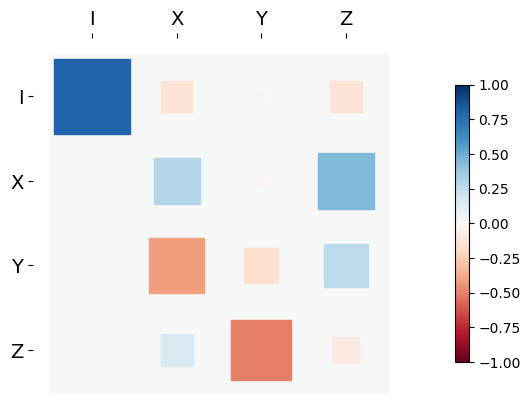

In [19]:
p_init = [1, 1, 0]  # amplitude, frequency, phase
q_init = [1, 1, 0]  # q[0] * sin(q[1] * t + q[2])
r_init = [1, 1, 0]

init_evo = qt.mesolve(H, initial, interval.tslots,
                      options={'normalize_output': False},
                      args={"p": p_init, "q": q_init, "r": r_init})

qt.hinton(init_evo.final_state)

<img src="doc_images\QOC.png" alt="crab" width="600"/>

In [20]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "GOAT",  # new
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={  # new
        "max_iter": 0,
        "seed": 1,
    },
)

In [21]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-12-09 22:12:30
- Number of objectives: 1
- Final fidelity error: 0.044040317765246945
- Final parameters: [[0.9872107789423857, 0.6502041233808173, 2.146218521690915], [1.0, 0.9840285098193846, 0.0345411175335696], [0.25457974367988706, 0.009564472323461809, 1.6823798172819167]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-12-09 22:12:33 (2.7002s)

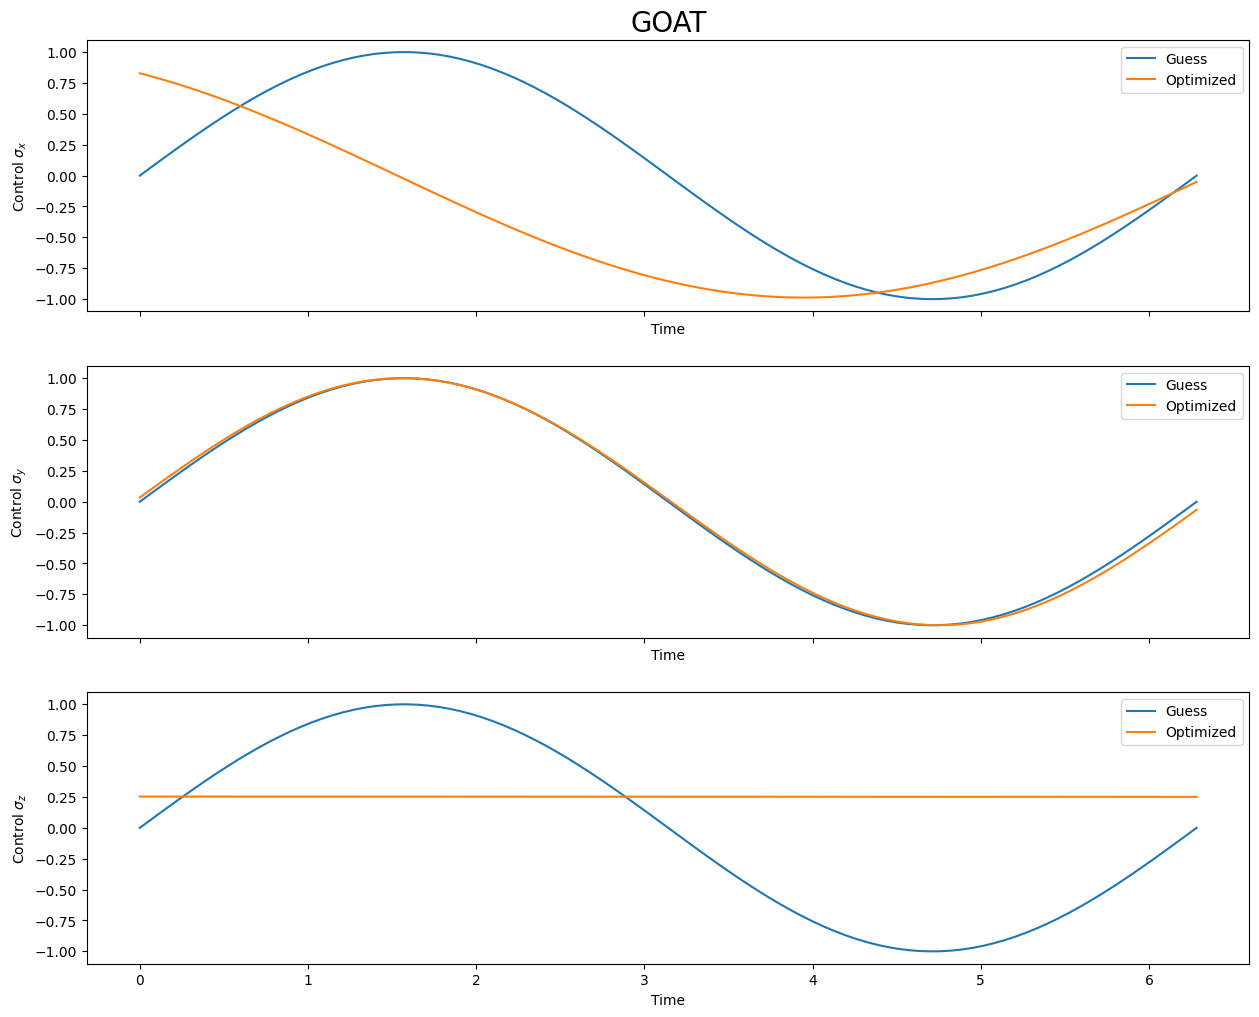

In [22]:
plot_result(res_goat, "GOAT")

# QuTiP JAX

In [23]:
def sin_jax(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])

In [24]:
@jax.jit
def sin_x_jax(t, p, **kwargs):
    return sin_jax(t, p)


@jax.jit
def sin_y_jax(t, q, **kwargs):
    return sin_jax(t, q)


@jax.jit
def sin_z_jax(t, r, **kwargs):
    return sin_jax(t, r)

In [25]:
H_jax = [H_d,
         [H_c[0], sin_x_jax],
         [H_c[1], sin_y_jax],
         [H_c[2], sin_z_jax]]

In [26]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    algorithm_kwargs={
        "alg": "JOAT",  # new
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    }
)

I0000 00:00:1702156353.859758       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [27]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-12-09 22:12:34
- Number of objectives: 1
- Final fidelity error: 0.04695324050521448
- Final parameters: [[0.8470165165373336, 0.9526285668298818, 1.236939169571649], [0.9713650201338212, 0.2934218150353567, 2.690065780704445], [0.9875029934011829, 0.2086633664954373, 1.9334104352229826]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-12-09 22:12:37 (3.259s)

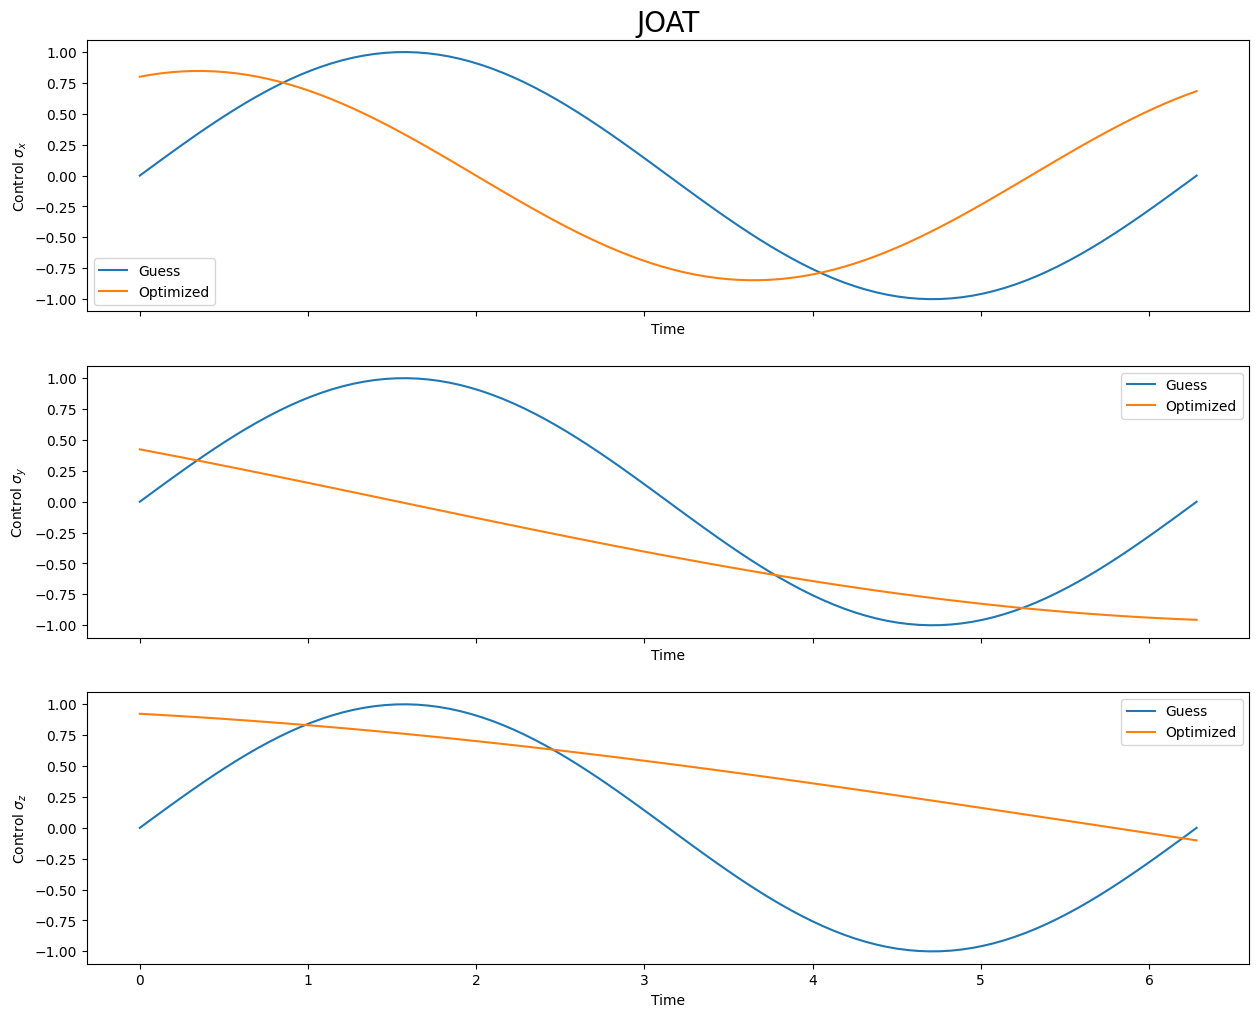

In [28]:
plot_result(res_joat, "JOAT")

# Time Optimization

In [29]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    time_options={  # new
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    minimizer_kwargs={},
    integrator_kwargs={  # only for comparison
        "atol": 1e-5,
        "rtol": 1e-5,
        "method": "dop853",
    },
)

In [30]:
res_goat

Control Optimization Result
--------------------------
- Started at 2023-12-09 22:12:38
- Number of objectives: 1
- Final fidelity error: 0.04412289765337241
- Final parameters: [[0.9256445507479785, 1.0, 0.11852387873935126], [1.0, 0.6054932980156238, 1.7620175091852557], [1.0, 0.896304909287583, 0.5314537468767817], [5.834235876800006]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-12-09 22:12:38 (0.4704s)

In [31]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options={
        "p": {
            "guess": p_init,
            "bounds": [(-1, 1), (0, 1), (0, 10 * π)],
        },
        "q": {
            "guess": q_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        },
        "r": {
            "guess": r_init,
            "bounds": [(-1, 1), (0, 1), (0, 2 * π)],
        }
    },
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    minimizer_kwargs={},
    integrator_kwargs={  # only for comparison
        "stepsize_controller": PIDController(
            atol=1e-5,
            rtol=1e-5,
        ),
        "solver": Dopri8(),
    },
)

In [32]:
res_joat

Control Optimization Result
--------------------------
- Started at 2023-12-09 22:12:38
- Number of objectives: 1
- Final fidelity error: 0.04368576638198034
- Final parameters: [[0.9851143699855616, 1.0, 0.18552456971899312], [1.0, 0.5248170402238282, 2.0216727496280225], [1.0, 0.892618506686271, 0.5519682900756491], [5.757902627097109]]
- Number of iterations: 1
- Reason for termination: ['requested number of basinhopping iterations completed successfully']
- Ended at 2023-12-09 22:12:42 (3.4518s)

# Scale-up

In [33]:
N = 2  # number of qubits

initial = qt.tensor([qt.qeye(2)] * N)
target = qt.tensor([hadamard()] * N)

initial = qt.sprepost(initial, initial.dag())
target = qt.sprepost(target, target.dag())

In [34]:
σx = qt.sigmax()
σy = qt.sigmay()
σz = qt.sigmaz()

ω, Δ, γ, π = 0.1, 1.0, 0.1, np.pi

Hd = 1 / 2 * (ω * σz + Δ * σx)

H_d = qt.liouvillian(H=qt.tensor([Hd] * N),
                     c_ops=[np.sqrt(γ) * qt.tensor([qt.sigmam()] * N)])

\begin{align*}
    c(t,\vec \alpha) = \sum_{l=0}^{\mathrm{n_{sup}-1}} a_l \sin ( \omega_l t + \phi_l )
\end{align*}

In [35]:
n_sup = 3
n_var = 3
n_tot = n_sup * n_var

interval = TimeInterval(evo_time=2 * π, n_tslots=1000)

In [36]:
from qutip_qoc.pulse import SinPulse

import string
import random

sin = SinPulse(n_sup, n_var)

# Generate random strings for the parameter names (e.g. 'abc')
# we need 3 * N different parameter names, one for each control
params = [''.join(random.choices(string.ascii_letters, k=3)) for _ in range(3*N)]

pulses, grads = [], []
for param in params:
    # functions with different parameter names
    pulses.append(eval('lambda t, {0}:    sin.gen_pulse(t, {0})'.format(param)))
    grads.append( eval('lambda t, {0}, i: sin.gen_grad(t, {0}, i)'.format(param)))

In [37]:
Hc = []
id = [qt.qeye(2) for _ in range(N)]

for i in range(N):  # 3N controls, assuming we can control each qubit individually
    sx, sy, sz = id.copy(), id.copy(), id.copy()
    sx[i], sy[i], sz[i] = σx, σy, σz
    Hc.append(qt.tensor(sx))
    Hc.append(qt.tensor(sy))
    Hc.append(qt.tensor(sz))

H_c = [qt.liouvillian(H) for H in Hc]

H = [H_d] + [[hc, pulse, {"grad": grad}] for hc, pulse, grad in zip(H_c, pulses, grads)]

In [38]:
p_init = np.ones(n_tot)

In [39]:
def sin_(t, α):
    return α[0] * jnp.sin(α[1] * t + α[2])


pulse_vmap = jax.vmap(sin_, in_axes=(None, 0))

def sin_sum(t, α):
    alpha = jnp.reshape(α, (n_sup, n_var))
    return jnp.sum(pulse_vmap(t, alpha), axis=0)

jax_pulses = [] 
for param in params:
    # functions with different parameter names
    jax_pulses.append(eval('lambda t, {0}, **kwargs: sin_sum(t, {0})'.format(param)))

jit_pulses = [jax.jit(pulse) for pulse in jax_pulses]

In [40]:
H_jax = [H_d] + [[hc, pulse] for hc, pulse in zip(H_c, jit_pulses)]

In [41]:
p_options = {}
for p in range(len(H_c)):
    p_options[p] = {
        "guess": 0.1 * np.ones(n_tot),
        "bounds": [(-2 * π, 2 * π) for _ in range(n_tot)],
    }

# JOAT

In [42]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.01,
        "disp": True,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    minimizer_kwargs={},
    integrator_kwargs={
        "stepsize_controller": PIDController(
            atol=1e-8,
            rtol=1e-8,
        ),
        "solver": Dopri5(),
    },
)

minimizer step, infidelity: 0.78593
minimizer step, infidelity: 0.78040
minimizer step, infidelity: 0.76501
minimizer step, infidelity: 0.75605
minimizer step, infidelity: 0.75266
minimizer step, infidelity: 0.73619
minimizer step, infidelity: 0.62837
minimizer step, infidelity: 0.59911
minimizer step, infidelity: 0.59566
minimizer step, infidelity: 0.59553
minimizer step, infidelity: 0.59551
minimizer step, infidelity: 0.59551
optimizer step, infidelity: 0.59551, took 4.67 seconds


In [43]:
res_joat

Control Optimization Result
 --------------------------
 - Started at 2023-12-09 22:12:43
 - Number of objectives: 1
 - Final fidelity error: 0.595509430938681
 - Final parameters: [array([ 0.1543982 ,  0.30913724, -0.12375829,  0.1543982 ,  0.30913724,
-0.12375829,  0.1543982 ,  0.30913724, -0.12375829]), array([-0.14501237,  0.05995236, -0.19058557, -0.14501237,  0.05995236,
-0.19058557, -0.14501237,  0.05995236, -0.19058557]), array([0.14160162, 0.15201748, 0.34771978, 0.14160162, 0.15201748,
0.34771978, 0.14160162, 0.15201748, 0.34771978]), array([ 0.1543982 ,  0.30913724, -0.12375829,  0.1543982 ,  0.30913724,
-0.12375829,  0.1543982 ,  0.30913724, -0.12375829]), array([-0.14501237,  0.05995236, -0.19058557, -0.14501237,  0.05995236,
-0.19058557, -0.14501237,  0.05995236, -0.19058557]), array([0.14160162, 0.15201748, 0.34771978, 0.14160162, 0.15201748,
0.34771978, 0.14160162, 0.15201748, 0.34771978]), [4.424754232037028]]
 - Number of iterations: 1
 - Reason for termination: ['req

# GOAT

In [44]:
print("system size:", H[0].shape[0])
print("number parameters:", n_tot)
print("number of controls:", len(H) - 1)
print("matrix size:", (1 + n_tot * (len(H) - 1)) * H[0].shape[0])

system size: 16
number parameters: 9
number of controls: 6
matrix size: 880


In [45]:
res_goat = optimize_pulses(
    objectives=[Objective(initial, H, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
        "disp": True,
    },
    optimizer_kwargs={
        "max_iter": 0,
        "seed": 1,
    },
    minimizer_kwargs={},
    integrator_kwargs={
        "atol": 1e-8,
        "rtol": 1e-8,
        "method": "dop853",
    },
)

minimizer step, infidelity: 0.78593
minimizer step, infidelity: 0.78040
minimizer step, infidelity: 0.76501
minimizer step, infidelity: 0.75605
minimizer step, infidelity: 0.75266
minimizer step, infidelity: 0.73619
minimizer step, infidelity: 0.62837
minimizer step, infidelity: 0.59843
minimizer step, infidelity: 0.59562
minimizer step, infidelity: 0.54539
minimizer step, infidelity: 0.43882
minimizer step, infidelity: 0.33980
minimizer step, infidelity: 0.32439
minimizer step, infidelity: 0.27658
minimizer step, infidelity: 0.24703
minimizer step, infidelity: 0.20408
minimizer step, infidelity: 0.18749
minimizer step, infidelity: 0.16527
minimizer step, infidelity: 0.14631
minimizer step, infidelity: 0.12757
minimizer step, infidelity: 0.11167
minimizer step, infidelity: 0.09328
minimizer step, infidelity: 0.08455
minimizer step, infidelity: 0.07814
minimizer step, infidelity: 0.06912
minimizer step, infidelity: 0.06313
minimizer step, infidelity: 0.05450
minimizer step, infidelity: 

In [46]:
res_goat

Control Optimization Result
 --------------------------
 - Started at 2023-12-09 22:12:47
 - Number of objectives: 1
 - Final fidelity error: 0.009190711300065478
 - Final parameters: [array([1.34909821, 1.84822177, 0.16727146, 1.34909821, 1.84822177,
0.16727146, 1.34909821, 1.84822177, 0.16727146]), array([-0.3241767 , -0.76563476, -0.49689475, -0.3241767 , -0.76563476,
-0.49689475, -0.3241767 , -0.76563476, -0.49689475]), array([0.87476064, 0.23145921, 1.05258003, 0.87476064, 0.23145921,
1.05258003, 0.87476064, 0.23145921, 1.05258003]), array([1.34909821, 1.84822177, 0.16727146, 1.34909821, 1.84822177,
0.16727146, 1.34909821, 1.84822177, 0.16727146]), array([-0.3241767 , -0.76563476, -0.49689475, -0.3241767 , -0.76563476,
-0.49689475, -0.3241767 , -0.76563476, -0.49689475]), array([0.87476064, 0.23145921, 1.05258002, 0.87476064, 0.23145921,
1.05258002, 0.87476064, 0.23145921, 1.05258002]), [0.47618187253810024]]
 - Number of iterations: 1
 - Reason for termination: fid_err_targ reach

# Global Optimization

# JOAT

In [47]:
res_joat = optimize_pulses(
    objectives=[Objective(initial, H_jax, target)],
    pulse_options=p_options,
    time_interval=interval,
    time_options={
        "guess": interval.evo_time,
        "bounds": (0, 2 * interval.evo_time),
    },
    algorithm_kwargs={
        "alg": "JOAT",
        "fid_err_targ": 0.001, # new
        "disp": True,
    },
    optimizer_kwargs={
        "method": "basinhopping",  # new
        "max_iter": 10,  # new
        "seed": 1,
    },
    minimizer_kwargs={},
    integrator_kwargs={
        "stepsize_controller": PIDController(
            atol=1e-8,
            rtol=1e-8,
        ),
        "solver": Dopri8(),
    },
)

minimizer step, infidelity: 0.78593
minimizer step, infidelity: 0.78040
minimizer step, infidelity: 0.76501
minimizer step, infidelity: 0.75605
minimizer step, infidelity: 0.75266
minimizer step, infidelity: 0.73619
minimizer step, infidelity: 0.62837
minimizer step, infidelity: 0.59912
minimizer step, infidelity: 0.59564
minimizer step, infidelity: 0.59552
minimizer step, infidelity: 0.59551
minimizer step, infidelity: 0.59551
minimizer step, infidelity: 0.54206
minimizer step, infidelity: 0.43097
minimizer step, infidelity: 0.35285
minimizer step, infidelity: 0.33493
minimizer step, infidelity: 0.29015
minimizer step, infidelity: 0.24251
minimizer step, infidelity: 0.19192
minimizer step, infidelity: 0.16945
minimizer step, infidelity: 0.09972
minimizer step, infidelity: 0.09623
minimizer step, infidelity: 0.08583
minimizer step, infidelity: 0.07478
minimizer step, infidelity: 0.06554
minimizer step, infidelity: 0.06170
minimizer step, infidelity: 0.05777
minimizer step, infidelity: 

In [48]:
res_joat

Control Optimization Result
 --------------------------
 - Started at 2023-12-09 22:13:04
 - Number of objectives: 1
 - Final fidelity error: 0.0009767545833804512
 - Final parameters: [array([3.44668268, 3.3511303 , 0.44770452, 3.33377608, 2.7753614 ,
0.52480826, 3.25370248, 2.95910608, 0.71643353]), array([-0.48985975, -3.3537807 ,  0.03624496, -0.70504086, -2.894082  ,
-0.60956805, -0.33028522, -3.35690602, -0.12262498]), array([ 2.05180242, -0.45899371,  1.71990571,  2.88035234, -0.3455817 ,
 1.61055986,  2.77914341,  0.22202725,  1.02028048]), array([2.98616145, 2.750461  , 0.83842462, 3.04501409, 2.9988007 ,
0.90829147, 3.48525038, 3.28660669, 0.29314145]), array([-0.21073269, -2.9394855 , -0.71369025, -0.26125099, -2.78284686,
 0.03893718, -0.62658044, -2.97981216, -0.57704124]), array([ 2.53626239,  0.25463959,  1.34352747,  2.35355423, -0.52093898,
 1.15491349,  2.76390157, -0.44112298,  1.34816585]), [0.15421159037659887]]
 - Number of iterations: 1
 - Reason for termination:

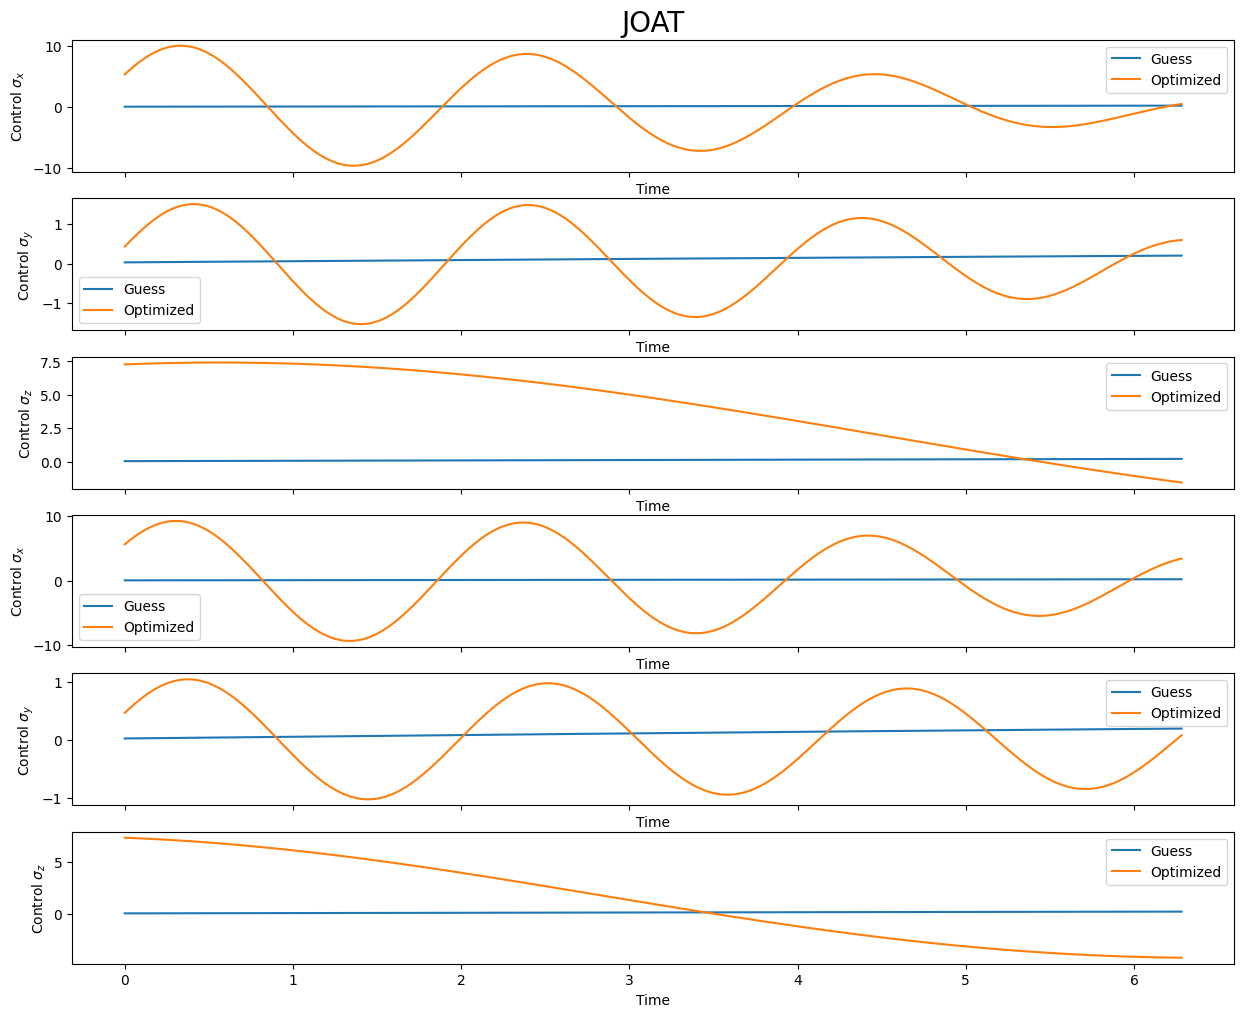

In [49]:
plot_result(
    res_joat,
    "JOAT",
    y_labels=[
        "$\\sigma_x$",
        "$\\sigma_y$",
        "$\\sigma_z$"] *
    N)

100.0%. Run time:   0.60s. Est. time left: 00:00:00:00
Total run time:   0.60s


(<Figure size 1500x400 with 6 Axes>, <Axes: title={'center': 'Target'}>)

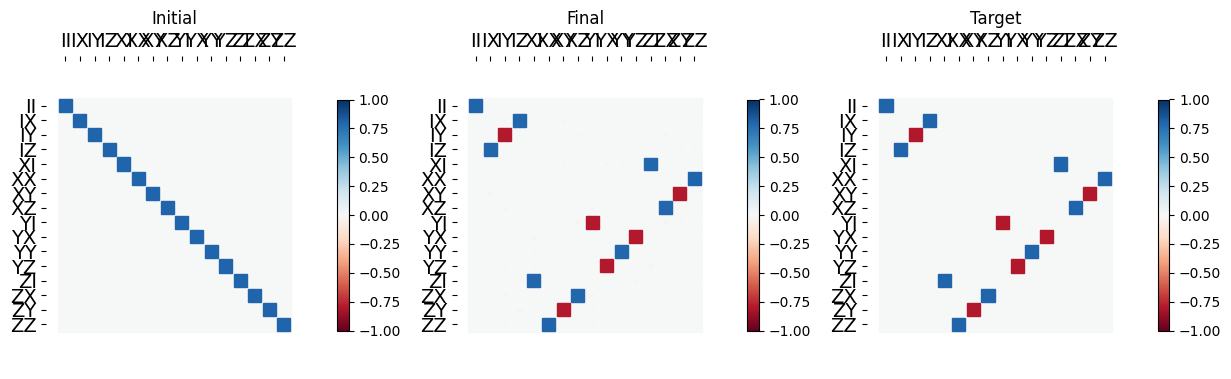

In [50]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.set_title('Initial')
ax1.set_title('Final')
ax2.set_title('Target')

qt.hinton(initial, ax=ax0)
qt.hinton(res_joat.final_states[0], ax=ax1)
qt.hinton(target, ax=ax2)